In [1]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky


In [2]:
#build toy dataset
def generate_samples_gauss(n_samples_class):
    cov = np.array([[10, 2], [2, 1]])
    mean1 = np.array([0, 0])
    mean2 = np.array([0, 5])

    total_n_samples = n_samples_class*2
    x =  np.zeros((total_n_samples, 2))

    x[:n_samples_class, 0], x[:n_samples_class, 1] = np.random.multivariate_normal(mean1, cov, n_samples_class).T
    x[n_samples_class:, 0], x[n_samples_class:, 1]  = np.random.multivariate_normal(mean2, cov, n_samples_class).T

    labels = np.zeros(total_n_samples)
    labels[n_samples_class:] = 1
    return x, labels

In [3]:
def generate_samples_uniform(n_samples_class):
    x[:,0] = np.random.rand(2*n_samples_class)
    x[n_samples_class:,1] = x[n_samples_class:,0] + 0.1
    x[:n_samples_class,1] = x[:n_samples_class,0] - 0.1
    
    labels = np.zeros(2*n_samples_class)
    labels[n_samples_class:] = 1
    return x, labels


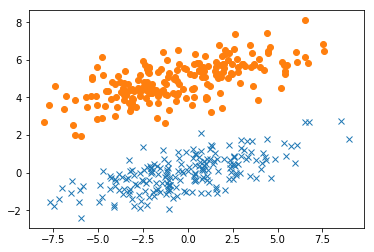

In [4]:
n_samples_class = 200
x, y  =  generate_samples_gauss(n_samples_class)
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')

plt.savefig("data_2d.png")
plt.show()

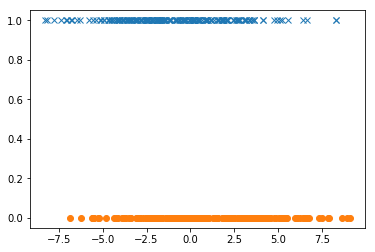

In [23]:
from sklearn.decomposition import PCA, FactorAnalysis
transformer = PCA(svd_solver='full', n_components='mle')
#transformer = FactorAnalysis(n_components=1, random_state=0)
x_proj_fa_python = transformer.fit_transform(x)
f_fa_python = transformer.components_
plt.plot(x_proj_fa_python[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_fa_python[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.savefig('data_proj_fa_python')
plt.show()

In [24]:
print transformer.components_
print transformer.mean_
print transformer.noise_variance_


[[0.91421901 0.40522043]]
[-0.38471298  2.43300911]
6.268262003230845


In [26]:
f_fa = transformer.components_.T
cov_noise_fa= np.diag(np.ones(x.shape[1])*transformer.noise_variance_)
bias_fa = np.mean(x, axis =0)

def compute_ll(f,bias,cov_noise, x):
    N = x.shape[0]
    D = x.shape[1]
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    ll = N*D*np.log(2*np.pi)/2
    ll += log_det_cov_x*N/2
    ll += np.sum(np.einsum("nd,dn->n", x - bias, temp1))/2
    return -ll

compute_ll(f_fa, bias_fa, cov_noise_fa, x)

-2001.4673301554344

In [42]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def objective_logit (params, x, y, latent_dim, lambda_e): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w, bias_y = decode_parameters_ppca(params, D, latent_dim)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias_x, temp1)
    
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w, mean_z) + bias_y
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    ll = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior
    return ll 


def decode_parameters(params, D, latent_dim, opt1):
    size_f = D*latent_dim
    f =  params[:size_f]
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt1=="ppca"):
        var = params[size_f+D]
        cov_noise= np.diag(np.ones(D)*np.log(1+np.exp(var)))
    else:
        cov_noise= np.diag(np.log(1+np.exp(var)))

    bias_y = params[size_f+D+1]
    w = params[size_f+D+2:]
    
    return f, bias_x, cov_noise, w, bias_y

def transform(f, bias, cov_noise, x):
    #alternative way of computing the mean_z to transform x 
    #ft_covi = np.dot(f.T, np.linalg.inv(cov_noise))
    #cov_z = np.linalg.inv(np.identity(latent_dim) + np.dot(ft_covi, f))
    #temp3 = np.dot( x - bias, ft_covi.T)
    #mean_z_alter = np.dot(temp3, cov_z)
    
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp = np.linalg.solve(cov_x, (x - bias).T)
    mean_z = np.einsum("dl,dn->nl", f, temp)
    #print np.allclose(mean_z_alter, mean_z, atol=1e-11, rtol=1e-11)
    return mean_z

In [44]:
latent_dim = 1 #suppose z is scalar
x_dim = 2      
params_size_ppca = x_dim*latent_dim + x_dim + 1 + 1 + latent_dim 
size_f = x_dim*latent_dim
params = np.random.rand(params_size_ppca)
f, bias, cov_noise, w, bias_y =  decode_parameters(params, x_dim, latent_dim, "ppca")
print "Initial parameters"
print "F:", f
print "slope", f[1]/f[0]
print "bias_x: ", bias
print "cov_noise matrix: ", cov_noise
print "regression weights: ",w
print "bias_y: ", bias_y
print "initial obj value logit", objective_logit(params, x, y, latent_dim, 0)

print compute_ll (f,bias,cov_noise,x)

Initial parameters
F: [[0.99938411]
 [0.16750089]]
slope [0.16760411]
bias_x:  [0.49619902 0.05259484]
cov_noise matrix:  [[1.06216011 0.        ]
 [0.         1.06216011]]
regression weights:  [0.07891642]
bias_y:  0.17914795924790106
initial obj value logit 4345.532692942203
-4345.532692942203


In [45]:
lambda_e = 100
#run minimizer use ADAM instead?
def pcallback(params):
    f, bias, cov_noise, w, bias_y= decode_parameters(params, 2, 1, "ppca")
    print compute_ll(f, bias, cov_noise, x)
    
grad_objective_logit = grad(objective_logit, argnum = 0)
params_optimizied_logit, obj_value_logit, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x,y,latent_dim,lambda_e), callback= pcallback, pgtol = 1e-2)
f_logit, bias_logit, cov_noise_logit, w_logit, bias_y_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, "ppca")
print "Final parameters_logit"
print "logit slope", f_logit[1]/f_logit[0]
print "F:", f_logit
print "mean: ", bias_logit
print "cov_noise matrix: ", cov_noise_logit
print "logistical regression weights: ", w_logit
print "bias for y: ", bias_y_logit

print "final objective value:", obj_value_logit

-3313.15741667153
-2646.786138173563
-2364.6864309623247
-2204.345326474112
-2202.0372081468195
-2208.15643740998
-2227.396188739248
-2229.275063879517
-2218.8440093341783
-2199.6239973371585
-2143.890419151141
-2137.9726333555436
-2139.198517194387
-2145.1859919313147
-2144.6250331283377
-2136.4615853356026
-2096.785419026465
-2084.4126092655406
-2078.328130895926
-2071.629062359225
-2063.9144558715993
-2053.308761085127
-2050.6899395117616
-2052.835477433453
-2051.8748531791775
-2050.725302799052
-2050.1999755287
-2049.324318871584
-2045.8035676230757
-2046.4916512923094
-2038.954721229933
-2030.4147077304772
-2031.6712610726443
-2030.0929884996624
-2029.4052968347496
-2028.0886312080002
-2027.3583903355493
-2025.9016840241477
-2024.3021069990818
-2023.4400083328337
-2022.609588963348
-2022.4729686950773
-2022.0846800763402
-2021.5422003566796
-2020.5417360412919
-2020.7106374067075
-2020.4282415102327
-2020.0659367577855
-2019.628229259109
-2019.633095378074
-2019.391786376962
-2019

In [46]:
print (np.einsum("dl,ml->dm",f_fa,f_fa) + cov_noise_fa)
print (np.einsum("dl,ml->dm",f_logit,f_logit) + cov_noise_logit)

[[7.10405841 0.37046022]
 [0.37046022 6.4324656 ]]
[[ 8.0712443  -0.35618076]
 [-0.35618076  9.53904168]]


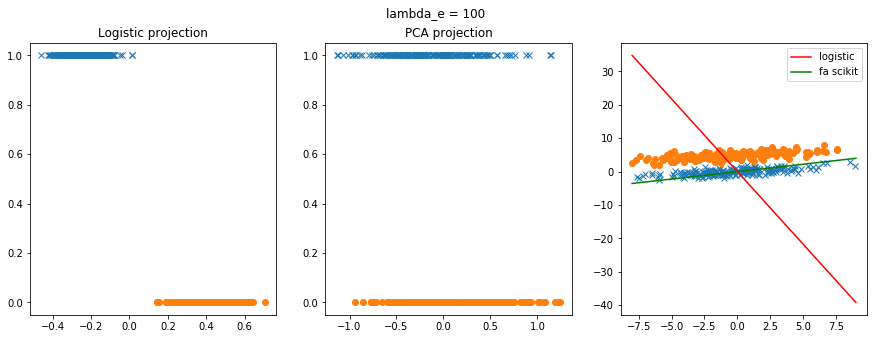

In [47]:
plt.figure(figsize=(15,5))

plt.subplot(131) 
plt.suptitle("lambda_e = {}".format(lambda_e))

plt.title("Logistic projection")
x_proj_logit = transform(f_logit, bias_logit, cov_noise_logit, x)
plt.plot(x_proj_logit[:n_samples_class], np.ones(n_samples_class), 'x')
plt.plot(x_proj_logit[n_samples_class:], np.zeros(n_samples_class), 'o')

plt.subplot(132) 
plt.title("PCA projection")
x_proj_fa_python = transform(f_fa, bias_fa, cov_noise_fa, x)

plt.plot(x_proj_fa_python[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_fa_python[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.subplot(133) 
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')
a = np.array(range(int(round(np.min(x[:,0]))), 1+int(round(np.max(x[:,0]))))) 
b_pc_fa_logit = f_logit[1]/f_logit[0]*a 
#b_pc_fa_norm = f_norm[1]/f_norm[0]*a 

b_std_fa = f_fa[1]/f_fa[0]*a

plt.plot(a, b_pc_fa_logit,  color ="r", label='logistic')
#plt.plot(a, b_pc_fa_norm,  color ="b", label='normal')
plt.plot(a, b_std_fa, color ="g", label='fa scikit')
plt.legend()

plt.savefig("data_lambda_e={}_logistic_norm.png".format(lambda_e))
plt.show()